In [1]:
# CNN Baseline model script for calcium signal prediction

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tifffile import imread
from skimage.transform import resize
from scipy.ndimage import median_filter
from skimage.filters import gaussian
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.empty_cache()

# ----------------------------
# CONFIG
# ----------------------------
CONFIG = {
    "resize_shape": (256, 256),
    "save_vis_dir": os.path.join(os.path.expanduser("~"), "Desktop", "CNN_Predictions")
}
os.makedirs(CONFIG["save_vis_dir"], exist_ok=True)



In [ ]:

# ----------------------------
# Preprocessing
# ----------------------------
def denoise_gaussian_median(frame, median_size=3, gaussian_sigma=1.0):
    return gaussian(median_filter(frame, size=median_size), sigma=gaussian_sigma)

# ----------------------------
# Sequence Loader
# ----------------------------
def load_tif_node_sequences(path, window=5, frame_skip=1, denoise_sigma=1.0, global_min=None, global_max=None):
    stack = imread(path)
    stack_denoised = np.array([denoise_gaussian_median(f, gaussian_sigma=denoise_sigma) for f in stack])
    stack_resized = np.array([resize(f, CONFIG["resize_shape"]) for f in stack_denoised])
    
    if global_min is None or global_max is None:
        raise ValueError("Global min/max must be provided for consistent normalization.")
    
    # Normalize using global min/max across all frames
    norm_stack = (stack_resized - global_min) / (global_max - global_min)
    norm_stack = norm_stack * 2 - 1  # scale to [-1, 1]

    flattened_stack = norm_stack.reshape(len(norm_stack), -1)

    sequences = []
    for i in range(0, len(flattened_stack) - window, frame_skip):
        seq = flattened_stack[i:i+window]
        target = flattened_stack[i+window]
        sequences.append((seq, target))

    # Debug prints once, outside the loop
    if len(sequences) > 0:
        seq, target = sequences[0]
        print("Sequence shape:", seq.shape)
        print("Target shape:", target.shape)
        print("Sequence min/max/mean/std:", np.min(seq), np.max(seq), np.mean(seq), np.std(seq))
        print("Target min/max/mean/std:", np.min(target), np.max(target), np.mean(target), np.std(target))

    return sequences



# ----------------------------
# Dataset
# ----------------------------
class FrameSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.data = sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, target = self.data[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)



In [3]:
# ----------------------------
# CNN Model
# ----------------------------

class SparseActivation(nn.Module):
    def __init__(self, threshold=0.05):  # tweak threshold as needed
        super().__init__()
        self.threshold = threshold

    def forward(self, x):
        return torch.sign(x) * F.relu(torch.abs(x) - self.threshold)

class TemporalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(1))  # [max_len, 1, d_model]

    def forward(self, x):
        return x + self.pe[:x.size(0)]  # x: [seq_len, batch, d_model]


class CalciumCNNWithAttention(nn.Module):
    def __init__(self, input_size, dropout=0.3, n_heads=4, seq_len=5):
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(dropout)

        # Positional encoding and attention
        self.pos_enc = TemporalPositionalEncoding(d_model=256, max_len=seq_len)
        self.attn = nn.MultiheadAttention(embed_dim=256, num_heads=n_heads, batch_first=False)

        self.reducer = nn.Sequential(
            nn.Linear(256 * seq_len, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.output = nn.Linear(64, input_size)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size, seq_len, input_size = x.shape  # [B, 5, 262144]
        assert seq_len == self.seq_len, f"Expected seq_len={self.seq_len}, got {seq_len}"
        
        x = x.view(batch_size * seq_len, 1, self.input_size)  # [B*5, 1, 262144]
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))     # [B*5, 64, L]
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))     # [B*5, 128, L]
        x = self.dropout(F.relu(self.bn3(self.conv3(x))))     # [B*5, 256, L]

        x = x.mean(dim=2)  # Global avg pool over last dim → [B*5, 256]
        x = x.view(batch_size, seq_len, 256)  # [B, 5, 256]
        x = x.permute(1, 0, 2)  # [5, B, 256] for attention

        x = self.pos_enc(x)  # Add temporal position info
        attn_out, _ = self.attn(x, x, x)  # [5, B, 256]
        attn_out = attn_out.permute(1, 0, 2).contiguous().view(batch_size, -1)  # [B, 5*256]

        print("📈 Attention output variance:", torch.var(attn_out).item())
        features = self.reducer(attn_out)
        return self.output(features)



In [4]:

def train_model(model, loader, optimizer, loss_fn_main, loss_fn_alt, device, l1_lambda=1e-4):
    model.train()
    total_main = 0
    total_alt = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss_main = loss_fn_main(out, y)

        # ➕ Add sparsity loss on the output
        l1_loss = l1_lambda * torch.norm(out, 1)
        total_loss = loss_main + l1_loss

        loss_alt = loss_fn_alt(out, y)

        total_loss.backward()
        optimizer.step()
        total_main += loss_main.item()
        total_alt += loss_alt.item()
    return total_main / max(1, len(loader)), total_alt / max(1, len(loader))


def evaluate_model(model, loader, loss_fn_main, loss_fn_alt, device, return_preds=False):
    model.eval()
    total_main = 0
    total_alt = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss_main = loss_fn_main(out, y)
            loss_alt = loss_fn_alt(out, y)
            total_main += loss_main.item()
            total_alt += loss_alt.item()
            if return_preds:
                all_preds.append(out.cpu().numpy())
                all_targets.append(y.cpu().numpy())
    if return_preds:
        return total_main / len(loader), total_alt / len(loader), all_preds, all_targets
    return total_main / len(loader), total_alt / len(loader)


In [5]:

# ----------------------------
# Visualization Function (Saved)
# ----------------------------
def visualize_predictions(preds, targets, shape=(128, 128), num_examples=5):
    for i in range(min(num_examples, len(preds))):
        pred_img = preds[i].reshape(-1, *shape)
        target_img = targets[i].reshape(-1, *shape)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(pred_img[0], cmap='seismic')
        axes[0].set_title("Predicted")
        axes[1].imshow(target_img[0], cmap='seismic')
        axes[1].set_title("Ground Truth")
        axes[2].imshow(np.abs(pred_img[0] - target_img[0]), cmap='hot')
        axes[2].set_title("Difference")
        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        save_path = os.path.join(CONFIG["save_vis_dir"], f"cnn_example_{i}.png")
        plt.savefig(save_path)
        plt.close()

📊 Global normalization range → min: 0.0000, max: 255.0000
Sequence shape: (5, 65536)
Target shape: (65536,)
Sequence min/max/mean/std: -1.0 1.0 -0.9844175925285011 0.06907411207875654
Target min/max/mean/std: -1.0 1.0 -0.9836729476781465 0.07291419641289475
Sequence shape: (5, 65536)
Target shape: (65536,)
Sequence min/max/mean/std: -1.0 1.0 -0.9844175925285011 0.06907411207875654
Target min/max/mean/std: -1.0 1.0 -0.9836729476781465 0.07291419641289475
Sequence shape: (5, 65536)
Target shape: (65536,)
Sequence min/max/mean/std: -1.0 1.0 -0.9844175925285011 0.06907411207875654
Target min/max/mean/std: -1.0 1.0 -0.9836729476781465 0.07291419641289475
Sequence shape: (5, 65536)
Target shape: (65536,)
Sequence min/max/mean/std: -1.0 1.0 -0.9844175925285011 0.06907411207875654
Target min/max/mean/std: -1.0 1.0 -0.9836729476781465 0.07291419641289475
Sequence shape: (5, 65536)
Target shape: (65536,)
Sequence min/max/mean/std: -1.0 1.0 -0.9844175925285011 0.06907411207875654
Target min/max/m

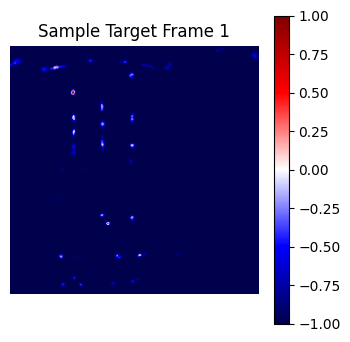

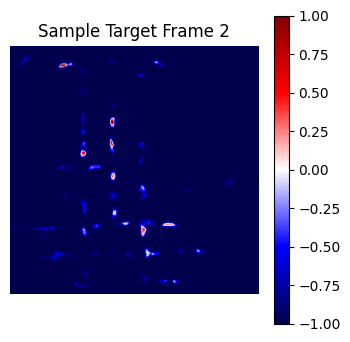

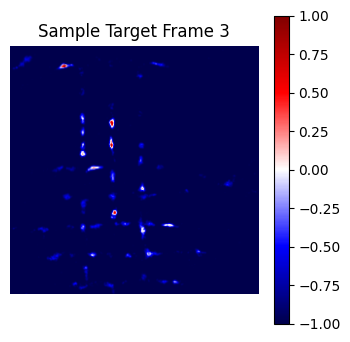

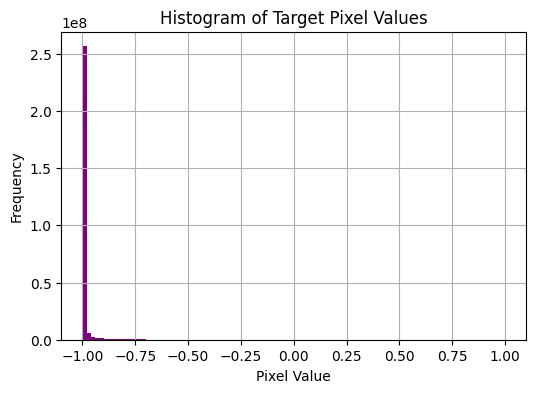

✅ No overlap detected between train/val/test splits.

📌 Model Architecture:
 CalciumCNNWithAttention(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pos_enc): TemporalPositionalEncoding()
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (reducer): Sequential(
    (0): Linear(in_features=1280, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=Tru

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.38 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 19.45 GiB is allocated by PyTorch, and 297.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [6]:
# ----------------------------
# Main Training Block
# ----------------------------
if __name__ == "__main__":
    file_paths = [
        "C:/Users/Platypus/Documents/CellNet/Real_Time_CS_Experiment-1093.tif",
        "C:/Users/Platypus/Documents/CellNet/Flow prior to chemical stimulation_Figure6C.tif",
        "C:/Users/Platypus/Documents/CellNet/Figure8.tif",
        "C:/Users/Platypus/Documents/CellNet/5uM_per_litre_Figure6_ChemicalStimulation.tif",
        "C:/Users/Platypus/Documents/CellNet/Cell Knocked_Figure7.tif"
    ]
    all_stacks = []
    for path in file_paths:
        stack = imread(path)
        all_stacks.append(stack)

    all_stacks_np = np.concatenate(all_stacks, axis=0)
    global_min = np.min(all_stacks_np)
    global_max = np.max(all_stacks_np)

    print(f"\U0001F4CA Global normalization range → min: {global_min:.4f}, max: {global_max:.4f}")

    all_sequences = []
    for path in file_paths:
        seqs = load_tif_node_sequences(path, window=5, global_min=global_min, global_max=global_max)
        all_sequences.extend(seqs)

    all_targets = np.array([target for _, target in all_sequences])
    print("Target stats:")
    print("  Min:", np.min(all_targets))
    print("  Max:", np.max(all_targets))
    print("  Mean:", np.mean(all_targets))
    print("  Std:", np.std(all_targets))

    for i in range(3):
        frame = all_targets[np.random.randint(0, len(all_targets))]
        reshaped = frame.reshape(CONFIG["resize_shape"])
        plt.figure(figsize=(4, 4))
        plt.imshow(reshaped, cmap='seismic', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(f"Sample Target Frame {i+1}")
        plt.axis("off")
        plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(all_targets.flatten(), bins=100, color="purple")
    plt.title("Histogram of Target Pixel Values")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    train_val, test_seq = train_test_split(all_sequences, test_size=0.15, random_state=42)
    train_seq, val_seq = train_test_split(train_val, test_size=0.176, random_state=42)

    train_set = set(map(lambda x: x[0].tobytes(), train_seq))
    val_set = set(map(lambda x: x[0].tobytes(), val_seq))
    test_set = set(map(lambda x: x[0].tobytes(), test_seq))

    assert train_set.isdisjoint(val_set), "Overlap between train and val!"
    assert train_set.isdisjoint(test_set), "Overlap between train and test!"
    assert val_set.isdisjoint(test_set), "Overlap between val and test!"
    print("✅ No overlap detected between train/val/test splits.")

    train_ds = FrameSequenceDataset(train_seq)
    val_ds = FrameSequenceDataset(val_seq)
    test_ds = FrameSequenceDataset(test_seq)

    train_loader = DataLoader(train_ds, batch_size=14, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=14)
    test_loader = DataLoader(test_ds, batch_size=14)

    input_size = CONFIG["resize_shape"][0] * CONFIG["resize_shape"][1]
    model = CalciumCNNWithAttention(input_size=input_size).to("cuda" if torch.cuda.is_available() else "cpu")

    print("\n📌 Model Architecture:\n", model)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn_main = nn.L1Loss()
    loss_fn_alt = nn.SmoothL1Loss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float("inf")
    patience = 5
    patience_counter = 0

    train_losses = []
    train_alt_losses = []
    val_losses = []
    val_alt_losses = []
    val_maes = []
    val_corrs = []

    overfit_mode = False
    if overfit_mode:
        print("⚠️ Overfit mode active")
        train_loader = [next(iter(DataLoader(train_ds, batch_size=14, shuffle=True)))]

    for epoch in range(100):
        train_loss, train_alt = train_model(model, train_loader, optimizer, loss_fn_main, loss_fn_alt, device)
        val_loss, val_alt, val_preds, val_targets = evaluate_model(model, val_loader, loss_fn_main, loss_fn_alt, device, return_preds=True)
        train_losses.append(train_loss)
        train_alt_losses.append(train_alt)
        val_losses.append(val_loss)
        val_alt_losses.append(val_alt)

        val_preds_flat = np.concatenate(val_preds).flatten()
        val_targets_flat = np.concatenate(val_targets).flatten()
        val_mae = mean_absolute_error(val_targets_flat, val_preds_flat)
        val_corr, _ = pearsonr(val_preds_flat, val_targets_flat)
        val_maes.append(val_mae)
        val_corrs.append(val_corr)

        print(f"Epoch {epoch+1} | Train L1: {train_loss:.4f} | Huber: {train_alt:.4f} || Val L1: {val_loss:.4f} | Huber: {val_alt:.4f} | MAE: {val_mae:.4f} | Corr: {val_corr:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_cnn.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_cnn.pt"))
    test_main_loss, test_alt_loss, preds, targets = evaluate_model(model, test_loader, loss_fn_main, loss_fn_alt, device, return_preds=True)
    pred_flat = np.concatenate(preds).flatten()
    target_flat = np.concatenate(targets).flatten()

    corr, _ = pearsonr(pred_flat, target_flat)
    mae = mean_absolute_error(target_flat, pred_flat)

    print("\n✅ Final CNN Test Metrics:")
    print(f"  - Test Loss (L1):       {test_main_loss:.4f}")
    print(f"  - Test Loss (Huber):    {test_alt_loss:.4f}")
    print(f"  - MAE:                  {mae:.4f}")
    print(f"  - Pearson Correlation:  {corr:.4f}")

    print("\n🔎 Sample Predictions vs Targets:")
    for p, t in zip(pred_flat[:10], target_flat[:10]):
        print(f"  - Pred: {p:.4f} | Target: {t:.4f}")

    if len(np.unique(np.round(pred_flat, 4))) < 5:
        print("⚠️ WARNING: Model predictions are nearly constant! Check attention/loss/output.")

    visualize_predictions(preds, targets, shape=CONFIG["resize_shape"])

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train L1")
    plt.plot(epochs, val_losses, label="Val L1")
    plt.title("Main Loss (L1) over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_maes, label="Val MAE")
    plt.plot(epochs, val_corrs, label="Val Pearson Corr")
    plt.title("Val MAE & Correlation")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
torch.cuda.empty_cache()
